<a href="https://colab.research.google.com/github/John-G-Thomas/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/LS_DS_212.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2
- Do train/test split
- Use scikit-learn to fit a multiple regression
- Understand how ordinary least squares regression minimizes the sum of squared errors
- Define overfitting/underfitting and the bias/variance tradeoff

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries:
- matplotlib
- numpy
- pandas
- plotly
- scikit-learn

In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

# Do train/test split

## Overview

### Predict Elections! 🇺🇸🗳️

How could we try to predict the 2020 US Presidential election? 

According to Douglas Hibbs, a political science and economics professor, you can [explain elections with just two features, "Bread and Peace":](https://douglas-hibbs.com/background-information-on-bread-and-peace-voting-in-us-presidential-elections/)

> Aggregate two-party vote shares going to candidates of the party holding the presidency during the postwar era are well explained by just two fundamental determinants:
>
> (1) Positively by weighted-average growth of per capita real disposable personal income over the term.  
> (2) Negatively by cumulative US military fatalities (scaled to population) owing to unprovoked, hostile deployments of American armed forces in foreign wars. 

Let's look at the data that Hibbs collected and analyzed:

In [2]:
import pandas as pd
df = pd.read_csv(DATA_PATH+'elections/bread_peace_voting.csv')
df

,Year,Incumbent Party Candidate,Other Candidate,Average Recent Growth in Personal Incomes,US Military Fatalities per Million,Incumbent Party Vote Share
0,1952,Stevenson,Eisenhower,2.40,190,44.60
1,1956,Eisenhower,Stevenson,2.89,0,57.76
2,1960,Nixon,Kennedy,0.85,0,49.91
3,1964,Johnson,Goldwater,4.21,1,61.34
4,1968,Humphrey,Nixon,3.02,146,49.60
5,1972,Nixon,McGovern,3.62,0,61.79
6,1976,Ford,Carter,1.08,2,48.95
7,1980,Carter,Reagan,-0.39,0,44.70
8,1984,Reagan,Mondale,3.86,0,59.17
9,1988,"Bush, Sr.",Dukakis,2.27,0,53.94


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 6 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Year                                       17 non-null     int64  
 1   Incumbent Party Candidate                  17 non-null     object 
 2   Other Candidate                            17 non-null     object 
 3   Average Recent Growth in Personal Incomes  17 non-null     float64
 4   US Military Fatalities per Million         17 non-null     int64  
 5   Incumbent Party Vote Share                 17 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 944.0+ bytes


- Vector for little y 

In [4]:
 y= df['Incumbent Party Vote Share']
 y.shape

(17,)

- Big X is target drop little y 

In [5]:
X = df.drop('Incumbent Party Vote Share', axis=1)
X.shape

(17, 5)

Data Sources & Definitions

- 1952-2012: Douglas Hibbs, [2014 lecture at Deakin University Melbourne](http://www.douglas-hibbs.com/HibbsArticles/HIBBS-PRESVOTE-SLIDES-MELBOURNE-Part1-2014-02-26.pdf), Slide 40
- 2016, Vote Share: [The American Presidency Project](https://www.presidency.ucsb.edu/statistics/elections)
- 2016, Recent Growth in Personal Incomes: [The 2016 election economy: the "Bread and Peace" model final forecast](https://angrybearblog.com/2016/11/the-2016-election-economy-the-bread-and-peace-model-final-forecast.html)
- 2016, US Military Fatalities: Assumption that Afghanistan War fatalities in 2012-16 occured at the same rate as 2008-12

> Fatalities denotes the cumulative number of American military fatalities per millions of US population the in Korea, Vietnam, Iraq and Afghanistan wars during the presidential terms preceding the 1952, 1964, 1968, 1976 and 2004, 2008 and 2012 elections. —[Hibbs](http://www.douglas-hibbs.com/HibbsArticles/HIBBS-PRESVOTE-SLIDES-MELBOURNE-Part1-2014-02-26.pdf), Slide 33

Here we have data from the 1952-2016 elections. We could make a model to predict 1952-2016 election outcomes — but do we really care about that? 

No, not really. We already know what happened, we don't need to predict it.

This is explained in [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/), Chapter 2.2, Assessing Model Accuracy:

> In general, we do not really care how well the method works training on the training data. Rather, _we are interested in the accuracy of the predictions that we obtain when we apply our method to previously unseen test data._ Why is this what we care about? 
>
> Suppose that we are interested in developing an algorithm to predict a stock’s price based on previous stock returns. We can train the method using stock returns from the past 6 months. But we don’t really care how well our method predicts last week’s stock price. We instead care about how well it will predict tomorrow’s price or next month’s price. 
>
> On a similar note, suppose that we have clinical measurements (e.g. weight, blood pressure, height, age, family history of disease) for a number of patients, as well as information about whether each patient has diabetes. We can use these patients to train a statistical learning method to predict risk of diabetes based on clinical measurements. In practice, we want this method to accurately predict diabetes risk for _future patients_ based on their clinical measurements. We are not very interested in whether or not the method accurately predicts diabetes risk for patients used to train the model, since we already know which of those patients have diabetes.

So, we're really interested in the 2020 election — but we probably don't want to wait until then to evaluate our model.

There is a way we can estimate now how well our model will generalize in the future. We can't fast-forward time, but we can rewind it...

We can split our data in **two sets.** For example: 
1. **Train** a model on elections before 2008.
2. **Test** the model on 2008, 2012, 2016. 

This "backtesting" helps us estimate how well the model will predict the next elections going forward, starting in 2020.

In [6]:
X

,Year,Incumbent Party Candidate,Other Candidate,Average Recent Growth in Personal Incomes,US Military Fatalities per Million
0,1952,Stevenson,Eisenhower,2.40,190
1,1956,Eisenhower,Stevenson,2.89,0
2,1960,Nixon,Kennedy,0.85,0
3,1964,Johnson,Goldwater,4.21,1
4,1968,Humphrey,Nixon,3.02,146
5,1972,Nixon,McGovern,3.62,0
6,1976,Ford,Carter,1.08,2
7,1980,Carter,Reagan,-0.39,0
8,1984,Reagan,Mondale,3.86,0
9,1988,"Bush, Sr.",Dukakis,2.27,0


This is explained in [_Forecasting,_ Chapter 3.4,](https://otexts.com/fpp2/accuracy.html) Evaluating forecast accuracy:

> The accuracy of forecasts can only be determined by considering how well a model performs on new data that were not used when fitting the model.
>
>When choosing models, it is common practice to separate the available data into two portions, training and test data, where the training data is used to estimate any parameters of a forecasting method and the test data is used to evaluate its accuracy. Because the test data is not used in determining the forecasts, it should provide a reliable indication of how well the model is likely to forecast on new data.
>
>![](https://otexts.com/fpp2/fpp_files/figure-html/traintest-1.png)
>
>The size of the test set is typically about 20% of the total sample, although this value depends on how long the sample is and how far ahead you want to forecast. The following points should be noted.
>
>- A model which fits the training data well will not necessarily forecast well.
>- A perfect fit can always be obtained by using a model with enough parameters.
>- Over-fitting a model to data is just as bad as failing to identify a systematic pattern in the data.
>
>Some references describe the test set as the “hold-out set” because these data are “held out” of the data used for fitting. Other references call the training set the “in-sample data” and the test set the “out-of-sample data”. We prefer to use “training data” and “test data” in this book.

**How should we split: Randomly? Before/after a given date?**

I recommend you all read a great blog post, [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/), by fast.ai cofounder Rachel Thomas.

She gives great examples to answer the question “When is a random subset not good enough?” I’m not as opposed to random splits as Rachel Thomas seems to be. But it’s worth thinking about the trade-offs!

Time-based and random splits can both be useful, and you’ll get repeated hands-on practice with both during this unit! (She also talks about the distinction between validation & test sets, which we’ll introduce in the last lesson of this Sprint.)

## Follow Along

Split the data in two sets:
1. Train on elections before 2008.
2. Test on 2008 and after.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
y.head()

0    44.60
1    57.76
2    49.91
3    61.34
4    49.60
Name: Incumbent Party Vote Share, dtype: float64

In [9]:
X_train = X[X['Year']<2008]
y_train = y[y.index.isin(X_train.index)]

In [15]:
mask = X['Year'] < 2008

In [16]:
type(mask)

pandas.core.series.Series

In [20]:
X.loc[mask]

,Year,Incumbent Party Candidate,Other Candidate,Average Recent Growth in Personal Incomes,US Military Fatalities per Million
0,1952,Stevenson,Eisenhower,2.40,190
1,1956,Eisenhower,Stevenson,2.89,0
2,1960,Nixon,Kennedy,0.85,0
3,1964,Johnson,Goldwater,4.21,1
4,1968,Humphrey,Nixon,3.02,146
5,1972,Nixon,McGovern,3.62,0
6,1976,Ford,Carter,1.08,2
7,1980,Carter,Reagan,-0.39,0
8,1984,Reagan,Mondale,3.86,0
9,1988,"Bush, Sr.",Dukakis,2.27,0


- Query Way

In [21]:
X.query('Year < 2008')

,Year,Incumbent Party Candidate,Other Candidate,Average Recent Growth in Personal Incomes,US Military Fatalities per Million
0,1952,Stevenson,Eisenhower,2.40,190
1,1956,Eisenhower,Stevenson,2.89,0
2,1960,Nixon,Kennedy,0.85,0
3,1964,Johnson,Goldwater,4.21,1
4,1968,Humphrey,Nixon,3.02,146
5,1972,Nixon,McGovern,3.62,0
6,1976,Ford,Carter,1.08,2
7,1980,Carter,Reagan,-0.39,0
8,1984,Reagan,Mondale,3.86,0
9,1988,"Bush, Sr.",Dukakis,2.27,0


How many observations (rows) are in the train set? In the test set?

In [11]:
X_test = X[X['Year']>=2008]
y_test = y[y.index.isin(X_test.index)]

Note that this volume of data is at least two orders of magnitude smaller than we usually want to work with for predictive modeling.

There are other validation techniques that could be used here, such as [time series cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split), or [leave-one-out cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#leave-one-out-loo) for small datasets. However, for this module, let's start simpler, with train/test split. 

Using a tiny dataset is intentional here. It's good for learning because we can see all the data at once.

## Challenge

In your assignment, you will do train/test split, based on date.

# Use scikit-learn to fit a multiple regression

## Overview

We've done train/test split, and we're ready to fit a model. 

We'll proceed in 3 steps. The first 2 are review from the previous module. The 3rd is new.

- Begin with baselines (0 features) 
- Simple regression (1 feature)
- Multiple regression (2 features)

## Follow Along

### Begin with baselines (0 features)

What was the average Incumbent Party Vote Share, in the 1952-2004 elections?

In [24]:
# Get mean baseline
y_train.mean()

52.46857142857142

What if we guessed this number for every election? How far off would this be on average?

In [28]:
# Train Error
from sklearn.metrics import mean_absolute_error

y_pred = [y_train.mean()] * len(y_train)

In [29]:
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error (1952-2004 elections): {mae:.2f} percentage points')

Train Error (1952-2004 elections): 4.85 percentage points


In [30]:
# Test Error
y_pred = [y_train.mean()] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error (2008-16 elections): {mae:.2f} percentage points')

Test Error (2008-16 elections): 3.63 percentage points


### Simple regression (1 feature)

Make a scatterplot of the relationship between 1 feature and the target.

We'll use an economic feature: Average Recent Growth in Personal Incomes. ("Bread")

In [31]:
import pandas as pd
import plotly.express as px

px.scatter(
    X_train,
    x='Average Recent Growth in Personal Incomes',
    y=y_train,
    text='Year',
    title='US Presidential Elections, 1952-2004',
    trendline='ols',  # Ordinary Least Squares
)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



1952 & 1968 are outliers: The incumbent party got fewer votes than predicted by the regression. What do you think could explain those years? We'll come back to this soon, but first...

Use scikit-learn to fit the simple regression with one feature.

Follow the [5 step process](https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html#Basics-of-the-API), and refer to [Scikit-Learn LinearRegression documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [32]:
# 1. Import the appropriate estimator class from Scikit-Learn
from sklearn.linear_model import LinearRegression

In [33]:
# 2. Instantiate this class
model = LinearRegression()

In [37]:
# 4. Fit the model
model.fit(X_train[['Average Recent Growth in Personal Incomes']], y_train)
y_pred = model.predict(X_train[['Average Recent Growth in Personal Incomes']])
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error: {mae:.2f} percentage points')

Train Error: 2.65 percentage points


In [39]:
# 5. Apply the model to new data
y_pred = model.predict(X_test[['Average Recent Growth in Personal Incomes']])
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error: {mae:.2f} percentage points')

Test Error: 1.80 percentage points


How does the error compare to the baseline?

### Multiple regression (2 features)

Make a scatterplot of the relationship between 2 features and the target.

We'll add another feature: US Military Fatalities per Million. ("Peace" or the lack thereof.)

Rotate the scatterplot to explore the data. What's different about 1952 & 1968?

In [41]:
px.scatter_3d(
    X_train,
    x='Average Recent Growth in Personal Incomes', 
    y='US Military Fatalities per Million', 
    z=y_train, 
    text='Year', 
    title='US Presidential Elections, 1952-2004'
)

Use scikit-learn to fit a multiple regression with two features.

In [46]:
# TODO: Complete this cell

# Re-arrange X features matrices
features = ['Average Recent Growth in Personal Incomes', 
            'US Military Fatalities per Million']
print(f'Linear Regression, dependent on: {features}')


Linear Regression, dependent on: ['Average Recent Growth in Personal Incomes', 'US Military Fatalities per Million']


In [47]:
# TODO: Fit the model
lr = LinearRegression()
lr.fit(X_train[features], y_train)

mae = mean_absolute_error(y_train, lr.predict(X_train[features]))
print('Training error:', mae)

Training error: 1.3303221006874268


In [48]:
# TODO: Apply the model to new data

mae = mean_absolute_error(y_test, lr.predict(X_test[features]))
print('Testing error:', mae)

Testing error: 1.6341722692537293


How does the error compare to the prior model?

### Plot the plane of best fit

For a regression with 1 feature, we plotted the line of best fit in 2D. 

(There are many ways to do this. Plotly Express's `scatter` function makes it convenient with its `trendline='ols'` parameter.)

For a regression with 2 features, we can plot the plane of best fit in 3D!

(Plotly Express has a `scatter_3d` function but it won't plot the plane of best fit for us. But, we can write our own function, with the same "function signature" as the Plotly Express API.)

In [ ]:
import itertools
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression

def regression_3d(df, x, y, z, num=100, **kwargs):
    """
    Visualize linear regression in 3D: 2 features + 1 target
    
    df : Pandas DataFrame
    x : string, feature 1 column in df
    y : string, feature 2 column in df
    z : string, target column in df
    num : integer, number of quantiles for each feature
    """
    
    # Plot data
    fig = px.scatter_3d(df, x, y, z, **kwargs)
    
    # Fit Linear Regression
    features = [x, y]
    target = z
    model = LinearRegression()
    model.fit(df[features], df[target])    
    
    # Define grid of coordinates in the feature space
    xmin, xmax = df[x].min(), df[x].max()
    ymin, ymax = df[y].min(), df[y].max()
    xcoords = np.linspace(xmin, xmax, num)
    ycoords = np.linspace(ymin, ymax, num)
    coords = list(itertools.product(xcoords, ycoords))
    
    # Make predictions for the grid
    predictions = model.predict(coords)
    Z = predictions.reshape(num, num).T
    
    # Plot predictions as a 3D surface (plane)
    fig.add_trace(go.Surface(x=xcoords, y=ycoords, z=Z))
    
    return fig

In [ ]:
regression_3d(
    train,
    x='Average Recent Growth in Personal Incomes', 
    y='US Military Fatalities per Million', 
    z='Incumbent Party Vote Share', 
    text='Year', 
    title='US Presidential Elections, 1952-2004'
)

Where are 1952 & 1968 in relation to the plane? Which elections are the biggest outliers now?

Roll over points on the plane to see predicted incumbent party vote share (z axis), dependent on personal income growth (x axis) and military fatatlies per capita (y axis).

### Get and interpret coefficients

During the previous module, we got the simple regression's coefficient and intercept. We plugged these numbers into an equation for the line of best fit, in slope-intercept form: $y = mx + b$

Let's review this objective, but now for multiple regression.

What's the equation for the plane of best fit?

$y = \beta_0 + \beta_1x_1 + \beta_2x_2$

Can you relate the intercept and coefficients to what you see in the plot above?

In [49]:
lr.intercept_, lr.coef_

(46.25489966153873, array([ 3.59004735, -0.05315709]))

In [52]:
beta0 = lr.intercept_
beta1, beta2 = lr.coef_
print(f'y = {beta0} + {beta1}x1 + {beta2}x2')

y = 46.25489966153873 + 3.5900473494560536x1 + -0.05315709351049324x2


In [53]:
# This is easier to read
print('Intercept', lr.intercept_)
coefficients = pd.Series(lr.coef_, features)
print(coefficients.to_string())

Intercept 46.25489966153873
Average Recent Growth in Personal Incomes    3.590047
US Military Fatalities per Million          -0.053157


One of the coefficients is positive, and the other is negative. What does this mean?

Let's look at some scenarios. We'll see that one unit's change in an independent variable results in a coefficient worth of change in the dependent variable.

What does the model predict if income growth=0%, fatalities=0

In [54]:
lr.predict([[0, 0]])

array([46.25489966])

Income growth = 1% (fatalities = 0)

In [55]:
lr.predict([[1, 0]])

array([49.84494701])

The difference between these predictions = ? 

In [57]:
lr.predict([[1, 0]]) - lr.predict([[0, 0]])

array([3.59004735])

What if... income growth = 2% (fatalities = 0)

In [58]:
lr.predict([[2, 0]])

array([53.43499436])

The difference between these predictions = ?

In [59]:
lr.predict([[2, 0]]) - lr.predict([[1, 0]])

array([3.59004735])

What if... (income growth=2%) fatalities = 100

In [60]:
lr.predict([[2, 100]])

array([48.11928501])

The difference between these predictions = ?

In [61]:
lr.predict([[2, 100]]) - lr.predict([[2, 0]])

array([-5.31570935])

What if income growth = 3% (fatalities = 100)

In [62]:
lr.predict([[3, 100]])

array([51.70933236])

The difference between these predictions = ?

In [63]:
lr.predict([[3, 100]]) - lr.predict([[2, 100]])

array([3.59004735])

What if (income growth = 3%) fatalities = 200

In [64]:
lr.predict([[3, 200]])

array([46.39362301])

The difference between these predictions = ?

In [65]:
lr.predict([[3, 200]]) - lr.predict([[3, 100]])

array([-5.31570935])

## Challenge

In your assignment, you'll fit a Linear Regression with at least 2 features.

# Understand how ordinary least squares regression minimizes the sum of squared errors

## Overview

So far, we've evaluated our models by their absolute error. It's an intuitive metric for regression problems.

However, ordinary least squares doesn't directly minimize absolute error. Instead, it minimizes squared error.




In this section, we'll introduce two new regression metrics: 

- Squared error
- $R^2$


We'll demostrate two possible methods to minimize squared error:

- Guess & check
- Linear Algebra

## Follow Along

### Guess & Check

This function visualizes squared errors. We'll go back to simple regression with 1 feature, because it's much easier to visualize.

Use the function's m & b parameters to "fit the model" manually. Guess & check what values of m & b minimize squared error.

In [66]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def squared_errors(df, feature, target, m, b):
    """
    Visualize linear regression, with squared errors,
    in 2D: 1 feature + 1 target.
    
    Use the m & b parameters to "fit the model" manually.
    
    df : Pandas DataFrame
    feature : string, feature column in df
    target : string, target column in df
    m : numeric, slope for linear equation
    b : numeric, intercept for linear requation
    """
    
    # Plot data
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    df.plot.scatter(feature, target, ax=ax)
    
    # Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    ax.plot(x, y_pred)
    
    # Plot squared errors
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale = (xmax-xmin)/(ymax-ymin)
    for x, y1, y2 in zip(x, y, y_pred):
        bottom_left = (x, min(y1, y2))
        height = abs(y1 - y2)
        width = height * scale
        ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
    
    # Print regression metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)

Here's what the mean baseline looks like:

In [67]:
feature = 'Average Recent Growth in Personal Incomes'
squared_errors(train, feature, target, m=0, b=y_train.mean())

NameError: ignored

Notice that $R^2$ is exactly zero. 

[$R^2$ represents the proportion of the variance for a dependent variable that is explained by the independent variable(s).](https://en.wikipedia.org/wiki/Coefficient_of_determination)

The mean baseline uses zero independent variables and explains none of the variance in the dependent variable, so its $R^2$ score is zero.

The highest possible $R^2$ score is 1. The lowest possible *Train* $R^2$ score with ordinary least squares regression is 0.

In this demo, it's possible to get a negative Train $R^2$, if you manually set values of m & b that are worse than the mean baseline. But that wouldn't happen in the real world.

However, in the real world, it _is_ possible to get a negative *Test/Validation* $R^2$. It means that your *Test/Validation* predictions are worse than if you'd constantly predicted the mean of the *Test/Validation* set.

---

Now that we've visualized the squared errors for the mean baseline, let's guess & check some better values for the m & b parameters:

In [68]:
squared_errors(train, feature, target, m=3, b=46)

NameError: ignored

You can run the function repeatedly, with different values for m & b.

How do you interpret each metric you see?

- Mean Squared Error
- Root Mean Squared Error
- Mean Absolute Error
- $R^2$

Does guess & check really get used in machine learning? Sometimes! Some complex functions are hard to minimize, so we use a sophisticated form of guess & check called "gradient descent", which you'll learn about in Unit 4.

Fortunately, we don't need to use guess & check for ordinary least squares regression. We have a solution, using linear algebra!


### Linear Algebra

The same result that is found by minimizing the sum of the squared errors can be also found through a linear algebra process known as the "Least Squares Solution:"

\begin{align}
\hat{\beta} = (X^{T}X)^{-1}X^{T}y
\end{align}

Before we can work with this equation in its linear algebra form we have to understand how to set up the matrices that are involved in this equation. 

#### The $\beta$ vector

The $\beta$ vector represents all the parameters that we are trying to estimate, our $y$ vector and $X$ matrix values are full of data from our dataset. The $\beta$ vector holds the variables that we are solving for: $\beta_0$ and $\beta_1$

Now that we have all of the necessary parts we can set them up in the following equation:

\begin{align}
y = X \beta + \epsilon
\end{align}

Since our $\epsilon$ value represents **random** error we can assume that it will equal zero on average.

\begin{align}
y = X \beta
\end{align}

The objective now is to isolate the $\beta$ matrix. We can do this by pre-multiplying both sides by "X transpose" $X^{T}$.

\begin{align}
X^{T}y =  X^{T}X \beta
\end{align}

Since anything times its transpose will result in a square matrix, if that matrix is then an invertible matrix, then we should be able to multiply both sides by its inverse to remove it from the right hand side. (We'll talk tomorrow about situations that could lead to $X^{T}X$ not being invertible.)

\begin{align}
(X^{T}X)^{-1}X^{T}y =  (X^{T}X)^{-1}X^{T}X \beta
\end{align}

Since any matrix multiplied by its inverse results in the identity matrix, and anything multiplied by the identity matrix is itself, we are left with only $\beta$ on the right hand side:

\begin{align}
(X^{T}X)^{-1}X^{T}y = \hat{\beta}
\end{align}

We will now call it "beta hat" $\hat{\beta}$ because it now represents our estimated values for $\beta_0$ and $\beta_1$

#### Lets calculate our $\beta$ parameters with numpy!

In [69]:
# This is NOT something you'll be tested on. It's just a demo.

# X is a matrix. Add column of constants for fitting the intercept.
def add_constant(X):
    constant = np.ones(shape=(len(X),1))
    return np.hstack((constant, X))
X = add_constant(train[features].values)
print('X')
print(X)

# y is a column vector
y = train[target].values[:, np.newaxis]
print('y')
print(y)

# Least squares solution in code
X_transpose = X.T
X_transpose_X = X_transpose @ X
X_transpose_X_inverse = np.linalg.inv(X_transpose_X)
X_transpose_y = X_transpose @ y
beta_hat = X_transpose_X_inverse @ X_transpose_y

print('Beta Hat')
print(beta_hat)

NameError: ignored

In [70]:
# Scikit-learn gave the exact same results!
model.intercept_, model.coef_

(45.82339516690145, array([3.17408624]))

# Define overfitting/underfitting and the bias/variance tradeoff

## Overview

Read [_Python Data Science Handbook,_ Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#The-Bias-variance-trade-off). Jake VanderPlas explains overfitting & underfitting:

> Fundamentally, the question of "the best model" is about finding a sweet spot in the tradeoff between bias and variance. Consider the following figure, which presents two regression fits to the same dataset:
> 
>![](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-bias-variance-2.png)
>
> The model on the left attempts to find a straight-line fit through the data. Because the data are intrinsically more complicated than a straight line, the straight-line model will never be able to describe this dataset well. Such a model is said to _underfit_ the data: that is, it does not have enough model flexibility to suitably account for all the features in the data; another way of saying this is that the model has high _bias_.
>
> The model on the right attempts to fit a high-order polynomial through the data. Here the model fit has enough flexibility to nearly perfectly account for the fine features in the data, but even though it very accurately describes the training data, its precise form seems to be more reflective of the particular noise properties of the data rather than the intrinsic properties of whatever process generated that data. Such a model is said to _overfit_ the data: that is, it has so much model flexibility that the model ends up accounting for random errors as well as the underlying data distribution; another way of saying this is that the model has high _variance_.

VanderPlas goes on to connect these concepts to the "bias/variance tradeoff":

> From the scores associated with these two models, we can make an observation that holds more generally:
>
>- For high-bias models, the performance of the model on the validation set is similar to the performance on the training set.
>
>- For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.
>
> If we imagine that we have some ability to tune the model complexity, we would expect the training score and validation score to behave as illustrated in the following figure:
>
>![](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png)
>
> The diagram shown here is often called a validation curve, and we see the following essential features:
>
>- The training score is everywhere higher than the validation score. This is generally the case: the model will be a better fit to data it has seen than to data it has not seen.
>- For very low model complexity (a high-bias model), the training data is under-fit, which means that the model is a poor predictor both for the training data and for any previously unseen data.
>- For very high model complexity (a high-variance model), the training data is over-fit, which means that the model predicts the training data very well, but fails for any previously unseen data.
>- For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.
>
>The means of tuning the model complexity varies from model to model.

So far, our only "means of tuning the model complexity" has been selecting one feature or two features for our linear regression models. But we'll quickly start to select more features, and more complex models, with more "hyperparameters."

This is just a first introduction to underfitting & overfitting. We'll continue to learn about this topic all throughout this unit.

## Follow Along

Let's make our own Validation Curve, by tuning a new type of model complexity: polynomial degrees in a linear regression.

Go back to the the NYC Tribeca condo sales data

In [71]:
# Read NYC Tribeca condo sales data, from first 4 months of 2019.
# Dataset has 90 rows, 9 columns.
df = pd.read_csv(DATA_PATH+'condos/tribeca.csv')
assert df.shape == (90, 9)

# Arrange X features matrix & y target vector
features = ['GROSS_SQUARE_FEET']
target = 'SALE_PRICE'
X = df[features]
y = df[target]

Do random [train/test split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

Repeatedly fit increasingly complex models, and keep track of the scores

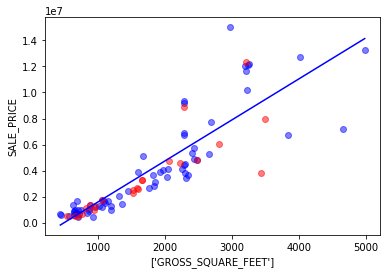

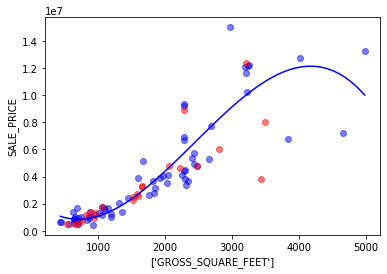

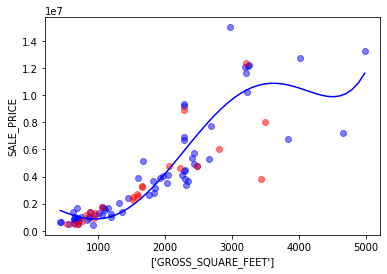

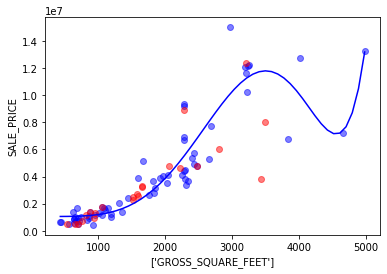

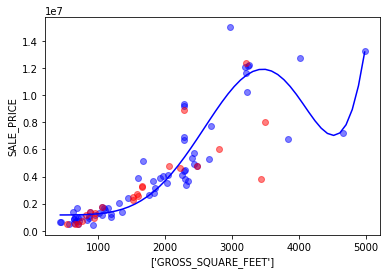

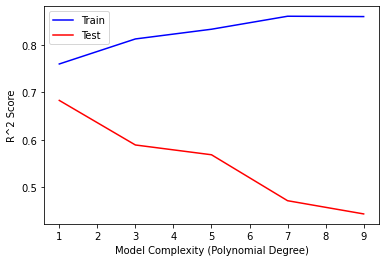

In [73]:
from IPython.display import display, HTML
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures


# Credit for PolynomialRegression: Jake VanderPlas, Python Data Science Handbook, Chapter 5.3
# https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), 
                         LinearRegression(**kwargs))


polynomial_degrees = range(1, 10, 2)
train_r2s = []
test_r2s = []

for degree in polynomial_degrees:
    model = PolynomialRegression(degree)
    display(HTML(f'Polynomial degree={degree}'))
    
    model.fit(X_train, y_train)
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    display(HTML(f'<b style="color: blue">Train R2 {train_r2:.2f}</b>'))
    display(HTML(f'<b style="color: red">Test R2 {test_r2:.2f}</b>'))

    plt.scatter(X_train, y_train, color='blue', alpha=0.5)
    plt.scatter(X_test, y_test, color='red', alpha=0.5)
    plt.xlabel(features)
    plt.ylabel(target)
    
    x_domain = np.linspace(X.min(), X.max())
    curve = model.predict(x_domain)
    plt.plot(x_domain, curve, color='blue')
    plt.show()
    display(HTML('<hr/>'))
    
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)
    
display(HTML('Validation Curve'))
plt.plot(polynomial_degrees, train_r2s, color='blue', label='Train')
plt.plot(polynomial_degrees, test_r2s, color='red', label='Test')
plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

As model complexity increases, what happens to Train $R^2$ and Test $R^2$?

# Review

In your assignment, you'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.


- Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- Engineer at least two new features.
- Fit a linear regression model with at least two features.
- Get the model's coefficients and intercept.
- Get regression metrics RMSE, MAE, and $R^2$, for both the train and test sets.

You've been provided with a separate notebook for your assignment, which has all the instructions and stretch goals. What's the best test MAE you can get? Share your score and features used with your cohort on Slack!

# Sources

#### Train/Test Split
- James, Witten, Hastie, Tibshirani, [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/), Chapter 2.2, Assessing Model Accuracy
- Hyndman, Athanasopoulos, [_Forecasting,_ Chapter 3.4,](https://otexts.com/fpp2/accuracy.html) Evaluating forecast accuracy
- Rachel Thomas, [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)

#### Bias-Variance Tradeoff
- Jake VanderPlas, [_Python Data Science Handbook,_ Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#The-Bias-variance-trade-off), Hyperparameters and Model Validation
- StatQuest, [Machine Learning Fundamentals: Bias and Variance](https://youtu.be/EuBBz3bI-aA) (6.5 minutes)

#### "Bread and Peace" Background
- Douglas Hibbs, [Background Information on the ‘Bread and Peace’ Model of Voting in Postwar US Presidential Elections](https://douglas-hibbs.com/background-information-on-bread-and-peace-voting-in-us-presidential-elections/)
- Nate Silver, [What Do Economic Models Really Tell Us About Elections?](https://fivethirtyeight.com/features/what-do-economic-models-really-tell-us-about-elections/)


#### "Bread and Peace" Data Sources & Definitions
- 1952-2012: Douglas Hibbs, [2014 lecture at Deakin University Melbourne](http://www.douglas-hibbs.com/HibbsArticles/HIBBS-PRESVOTE-SLIDES-MELBOURNE-Part1-2014-02-26.pdf), Slide 40
- 2016, Vote Share: [The American Presidency Project](https://www.presidency.ucsb.edu/statistics/elections)
- 2016, Recent Growth in Personal Incomes: [The 2016 election economy: the "Bread and Peace" model final forecast](https://angrybearblog.com/2016/11/the-2016-election-economy-the-bread-and-peace-model-final-forecast.html)
- 2016, US Military Fatalities: Assumption that Afghanistan War fatalities in 2012-16 occured at the same rate as 2008-12

> Fatalities denotes the cumulative number of American military fatalities per millions of US population the in Korea, Vietnam, Iraq and Afghanistan wars during the presidential terms preceding the 1952, 1964, 1968, 1976 and 2004, 2008 and 2012 elections. —[Hibbs](http://www.douglas-hibbs.com/HibbsArticles/HIBBS-PRESVOTE-SLIDES-MELBOURNE-Part1-2014-02-26.pdf), Slide 33